In [63]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
import numpy as np
from numpy import array

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF


import time
import itertools

import pickle

In [64]:
computer_technology_subclasses = ['comp.graphics',
                                  'comp.os.ms-windows.misc',
                                  'comp.sys.ibm.pc.hardware',
                                  'comp.sys.mac.hardware']

recreational_activity_subclasses = ['rec.autos',
                                    'rec.motorcycles',
                                    'rec.sport.baseball',
                                    'rec.sport.hockey']

categories = computer_technology_subclasses + recreational_activity_subclasses

In [65]:
dataset = fetch_20newsgroups(subset='all',categories=categories, shuffle=True, 
                             random_state=42, remove=('headers', 'footers'))

dataset_binary_target = [0 if t<4 else 1 for t in dataset.target]

In [66]:
# QUESTION 1: Report the dimensions of the TF-IDF matrix you get.

In [67]:
# Generate TF-IDF Data, with min_df=3, removed stop words, no stemming
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_counts = vectorizer.fit_transform(dataset.data)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

# Print the shape of the datasets
print("QUESTION 1: Report the dimensions of the TF-IDF matrix you get\n")
print('X_tfidf:',X_tfidf.shape)


QUESTION 1: Report the dimensions of the TF-IDF matrix you get

X_tfidf: (7882, 23522)


In [68]:
# QUESTION 2: Report the contingency table of your clustering result.

In [69]:
# QUESTION 3: Report the 5 measures above for the K-means clustering results you get.

In [70]:
# contingency table (confusion matrix)
def plot_contingency_table(cm, title='Contingency Table',
                           cmap=plt.cm.YlOrBr,
                           actual_class_names=['Class 1', 'Class 2'],
                           cluster_class_names=['Cluster 1', 'Cluster 2']):
    plt.gcf().clear()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(actual_class_names))
    plt.xticks(tick_marks, actual_class_names)
    plt.yticks(tick_marks, cluster_class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center")

    plt.tight_layout()
    plt.ylabel('Cluster Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)
    plt.show()
    
def k_means_clustering(training_data, n_clusters=8, random_state=None, max_iter=300, n_init=10):
    start = time.time()
    km = KMeans(n_clusters=n_clusters,random_state=random_state,max_iter=max_iter,n_init=n_init)
    km.fit(training_data)
    print("Finished clustering with %i seeds in %f seconds" % (n_init, time.time()-start))

    contin_matrix = metrics.cluster.contingency_matrix(dataset_binary_target, km.labels_)
    print("Show Contingency Matrix:")
    
    plot_contingency_table(contin_matrix)
    
    print("Report 5 Measures for K-Means Clustering")
    
    homogeneity = metrics.homogeneity_score(dataset_binary_target, km.labels_)
    completeness = metrics.completeness_score(dataset_binary_target, km.labels_)
    v_measure = metrics.v_measure_score(dataset_binary_target, km.labels_)
    adjusted_rand_index = metrics.adjusted_rand_score(dataset_binary_target, km.labels_)
    adjusted_mutual_info = metrics.adjusted_mutual_info_score(dataset_binary_target, km.labels_)

    print("Homogeneity Score: %f" % homogeneity)
    print("Completeness Score: %f" % completeness)
    print("V-Measure Score: %f" % v_measure)
    print("Adjusted Rand Index: %f" % adjusted_rand_index)
    print("Adjusted Mutual Information: %f" % adjusted_mutual_info)
    
    return {
        "homogeneity": homogeneity,
        "completeness": completeness,
        "v_measure": v_measure,
        "adjusted_rand_index": adjusted_rand_index,
        "adjusted_mutual_info": adjusted_mutual_info }


def svd_dimension_reduction(training_data, n_components=2):
    start = time.time()
    svd = TruncatedSVD(n_components = n_components)
    svd_dataset = svd.fit_transform(training_data)
    print("SVD complete after %f seconds" % (time.time()-start))
    return svd_dataset , svd

def nmf_dimension_reduction(training_data, n_components=None):
    start = time.time()
    nmf = NMF(n_components=n_components, random_state=0)
    nmf_dataset = nmf.fit_transform(training_data)
    print("NMF complete after %f seconds" % (time.time()-start))
    return nmf_dataset , svd

    
def plot_percent_variance(svd):
    plt.gcf().clear()
    print("Plot Percent of Variance")
    plt.plot(np.cumsum(svd.explained_variance_ratio_[:1000]))
    plt.xlabel("Dimension Index")
    plt.ylabel("Percentage of Total Variance")
    plt.show()    
    
def plot_histogram(method, measure, ydata, x_labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300'], height=range(1,10)):
    plt.gcf().clear()
    fig, ax = plt.subplots()
    ax.set_xticks([i+0.25 for i in height])
    ax.set_xticklabels(x_labels, fontsize = 12)
    
    rects = plt.bar([i for i in height], ydata, 0.5, align='edge', alpha = 0.8)
    plt.xlabel('Number of Principal Components r', fontsize = 14)
    plt.ylabel('Measure Score', fontsize = 14)
    plt.title(measure+' ('+method+')', fontsize = 18)
    plt.axis([0.5,10,0,1])
    
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height, '%.3f' % float(height), ha='center', va='bottom')
    
    plt.show()    


Finished clustering with 30 seeds in 123.002952 seconds
Show Contingency Matrix:


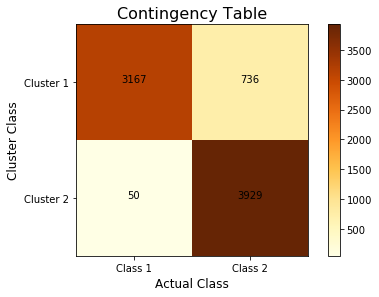

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.580535
Completeness Score: 0.595065
V-Measure Score: 0.587710
Adjusted Rand Index: 0.640848
Adjusted Mutual Information: 0.580496


In [71]:
# Apply K-means clustering with k=2 using the TF-IDF data. Use random_state=0, max_iter >= 1000, n_init>=30.

k_means = k_means_clustering(X_tfidf, n_clusters=2,random_state=0,max_iter=1000,n_init=30)


In [72]:
# QUESTION 4: Report the plot of the percent of variance the top r principle compo-
# nents can retain v.s. r, for r = 1 to 1000.

SVD complete after 18.391419 seconds
Plot Percent of Variance


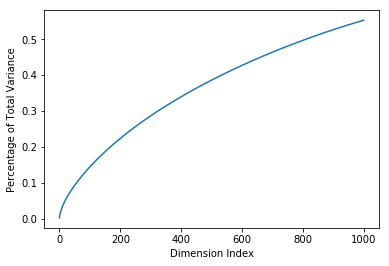

In [73]:
svd_dataset, svd = svd_dimension_reduction(X_tfidf, n_components = 1000)
plot_percent_variance(svd)

In [74]:
# QUESTION 5:
# Let r be the dimension that we want to reduce the data to (i.e. n components).
# Try r = 1; 2; 3; 5; 10; 20; 50; 100; 300, and plot the 5 measure scores v.s. r for both
# SVD and NMF.
# Report the best r choice for SVD and NMF respectively.
# Note: what is \best" after all? What if some measures contradict with each other? Here you are faced with this
# challenge that you need to decide which measure you value the most, and design your own standard of \best".
# Please explain your standard and justify it.

n_components: 1
SVD complete after 0.127678 seconds
Finished clustering with 30 seeds in 0.144575 seconds
Show Contingency Matrix:


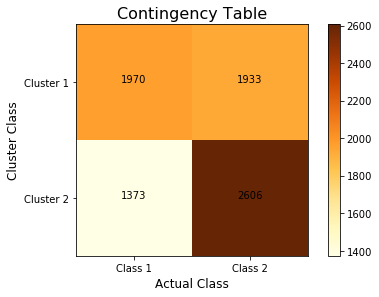

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.018910
Completeness Score: 0.019229
V-Measure Score: 0.019068
Adjusted Rand Index: 0.025839
Adjusted Mutual Information: 0.018820
n_components: 2
SVD complete after 0.113704 seconds
Finished clustering with 30 seeds in 0.150827 seconds
Show Contingency Matrix:


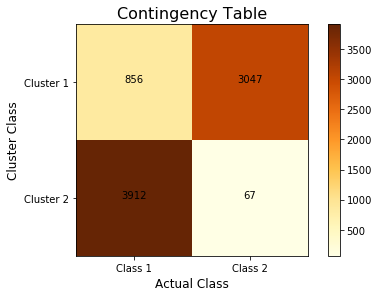

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.529987
Completeness Score: 0.547472
V-Measure Score: 0.538588
Adjusted Rand Index: 0.586391
Adjusted Mutual Information: 0.529944
n_components: 3
SVD complete after 0.114586 seconds
Finished clustering with 30 seeds in 0.147272 seconds
Show Contingency Matrix:


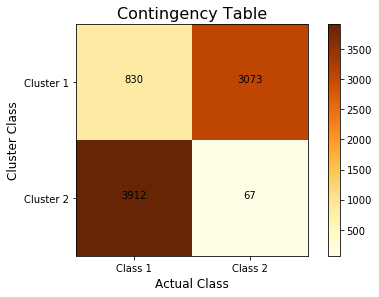

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.538118
Completeness Score: 0.554728
V-Measure Score: 0.546296
Adjusted Rand Index: 0.596540
Adjusted Mutual Information: 0.538076
n_components: 5
SVD complete after 0.134175 seconds
Finished clustering with 30 seeds in 0.161830 seconds
Show Contingency Matrix:


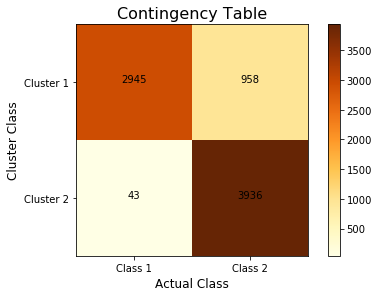

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.515851
Completeness Score: 0.538769
V-Measure Score: 0.527061
Adjusted Rand Index: 0.556466
Adjusted Mutual Information: 0.515807
n_components: 10
SVD complete after 0.156869 seconds
Finished clustering with 30 seeds in 0.238802 seconds
Show Contingency Matrix:


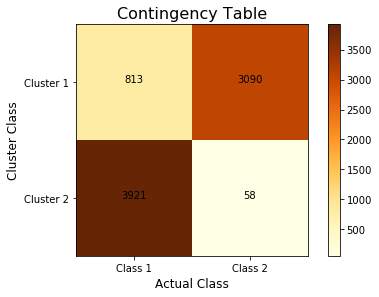

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.549651
Completeness Score: 0.566266
V-Measure Score: 0.557834
Adjusted Rand Index: 0.606776
Adjusted Mutual Information: 0.549609
n_components: 20
SVD complete after 0.282382 seconds
Finished clustering with 30 seeds in 0.368838 seconds
Show Contingency Matrix:


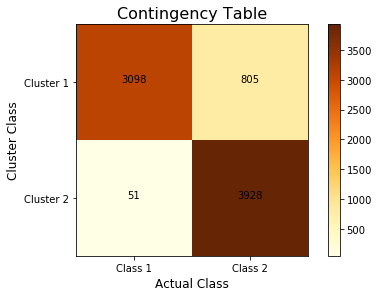

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.557171
Completeness Score: 0.573969
V-Measure Score: 0.565445
Adjusted Rand Index: 0.612721
Adjusted Mutual Information: 0.557130
n_components: 50
SVD complete after 0.627047 seconds
Finished clustering with 30 seeds in 0.599152 seconds
Show Contingency Matrix:


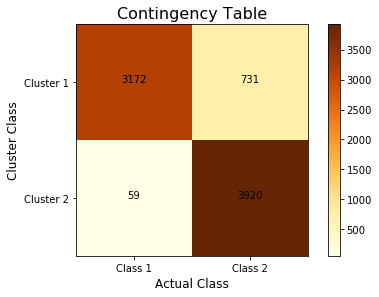

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.575770
Completeness Score: 0.589611
V-Measure Score: 0.582608
Adjusted Rand Index: 0.639224
Adjusted Mutual Information: 0.575731
n_components: 100
SVD complete after 1.067132 seconds
Finished clustering with 30 seeds in 1.351598 seconds
Show Contingency Matrix:


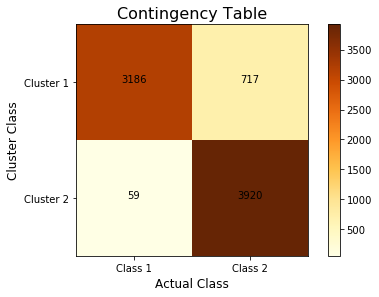

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.580485
Completeness Score: 0.593878
V-Measure Score: 0.587105
Adjusted Rand Index: 0.644918
Adjusted Mutual Information: 0.580447
n_components: 300
SVD complete after 3.262979 seconds
Finished clustering with 30 seeds in 3.588910 seconds
Show Contingency Matrix:


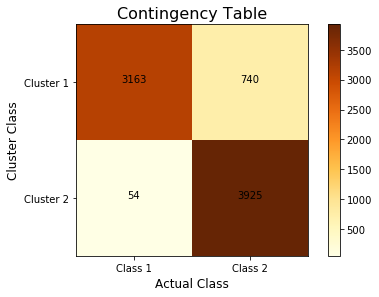

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.576302
Completeness Score: 0.590727
V-Measure Score: 0.583425
Adjusted Rand Index: 0.637602
Adjusted Mutual Information: 0.576264


In [75]:
svd_homogeneity_1 = []
svd_completeness_1 = []
svd_v_measure_1 = []
svd_adjusted_mutual_info_1 = []
svd_adjusted_rand_index_1 = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:', r)
    svd_dataset,svd = svd_dimension_reduction(X_tfidf, n_components = r)
    k_means = k_means_clustering(svd_dataset, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
    svd_homogeneity_1.append(k_means['homogeneity'])
    svd_completeness_1.append(k_means['completeness'])
    svd_v_measure_1.append(k_means['v_measure'])
    svd_adjusted_mutual_info_1.append(k_means['adjusted_mutual_info'])
    svd_adjusted_rand_index_1.append(k_means['adjusted_rand_index'])
    


n_components: 1
NMF complete after 0.150210 seconds
Finished clustering with 30 seeds in 0.151981 seconds
Show Contingency Matrix:


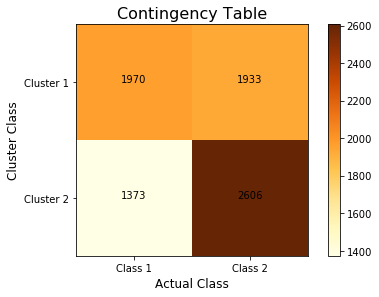

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.018910
Completeness Score: 0.019229
V-Measure Score: 0.019068
Adjusted Rand Index: 0.025839
Adjusted Mutual Information: 0.018820
n_components: 2
NMF complete after 0.320175 seconds
Finished clustering with 30 seeds in 0.118823 seconds
Show Contingency Matrix:


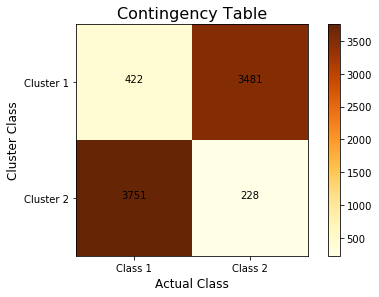

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.592964
Completeness Score: 0.594411
V-Measure Score: 0.593687
Adjusted Rand Index: 0.697299
Adjusted Mutual Information: 0.592927
n_components: 3
NMF complete after 0.435495 seconds
Finished clustering with 30 seeds in 0.117739 seconds
Show Contingency Matrix:


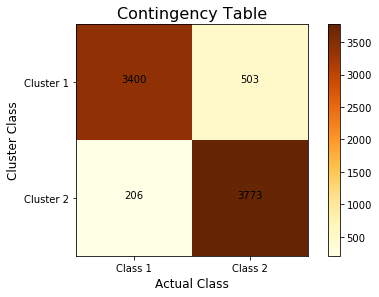

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.571965
Completeness Score: 0.574927
V-Measure Score: 0.573442
Adjusted Rand Index: 0.672517
Adjusted Mutual Information: 0.571926
n_components: 5
NMF complete after 1.691286 seconds
Finished clustering with 30 seeds in 0.175269 seconds
Show Contingency Matrix:


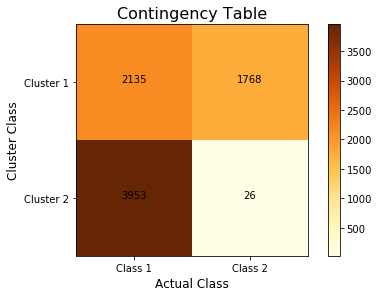

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.253134
Completeness Score: 0.327101
V-Measure Score: 0.285403
Adjusted Rand Index: 0.203906
Adjusted Mutual Information: 0.253065
n_components: 10
NMF complete after 1.108181 seconds
Finished clustering with 30 seeds in 0.218712 seconds
Show Contingency Matrix:


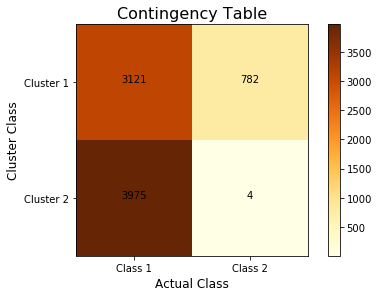

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.104493
Completeness Score: 0.223209
V-Measure Score: 0.142348
Adjusted Rand Index: 0.042771
Adjusted Mutual Information: 0.104411
n_components: 20
NMF complete after 3.159505 seconds
Finished clustering with 30 seeds in 0.288968 seconds
Show Contingency Matrix:


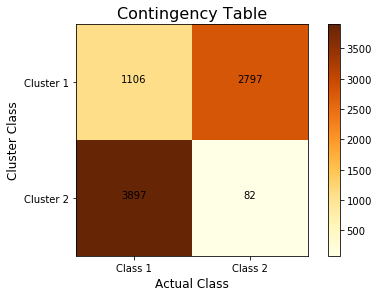

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.448020
Completeness Score: 0.473079
V-Measure Score: 0.460209
Adjusted Rand Index: 0.487914
Adjusted Mutual Information: 0.447969
n_components: 50
NMF complete after 27.389928 seconds
Finished clustering with 30 seeds in 0.580298 seconds
Show Contingency Matrix:


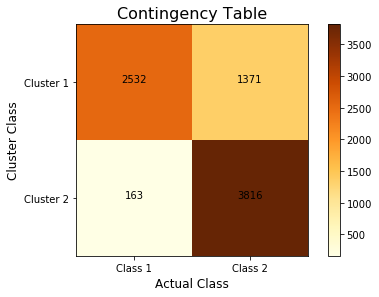

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.339037
Completeness Score: 0.365852
V-Measure Score: 0.351935
Adjusted Rand Index: 0.372949
Adjusted Mutual Information: 0.338976
n_components: 100
NMF complete after 99.517129 seconds
Finished clustering with 30 seeds in 0.677731 seconds
Show Contingency Matrix:


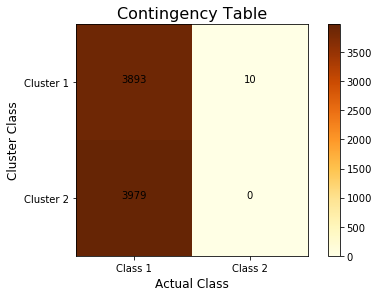

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.001288
Completeness Score: 0.091729
V-Measure Score: 0.002540
Adjusted Rand Index: 0.000055
Adjusted Mutual Information: 0.001191
n_components: 300
NMF complete after 693.163242 seconds
Finished clustering with 30 seeds in 2.652674 seconds
Show Contingency Matrix:


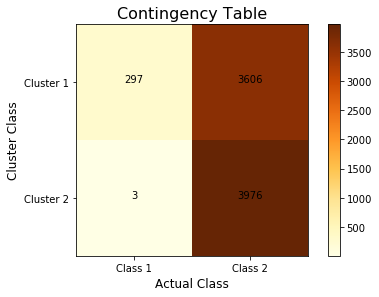

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.036575
Completeness Score: 0.156739
V-Measure Score: 0.059310
Adjusted Rand Index: 0.007000
Adjusted Mutual Information: 0.036486


In [76]:
nmf_homogeneity_1 = []
nmf_completeness_1 = []
nmf_v_measure_1 = []
nmf_adjusted_mutual_info_1 = []
nmf_adjusted_rand_index_1 = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:',r)
    nmf_dataset,nmf = nmf_dimension_reduction(X_tfidf, n_components = r)
    k_means = k_means_clustering(nmf_dataset, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
    nmf_homogeneity_1.append(k_means['homogeneity'])
    nmf_completeness_1.append(k_means['completeness'])
    nmf_v_measure_1.append(k_means['v_measure'])
    nmf_adjusted_mutual_info_1.append(k_means['adjusted_mutual_info'])
    nmf_adjusted_rand_index_1.append(k_means['adjusted_rand_index'])
    


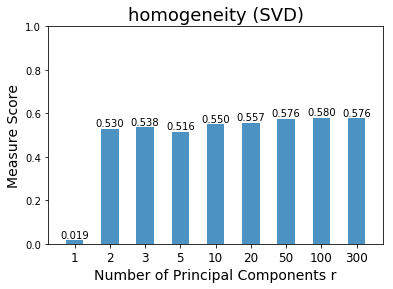

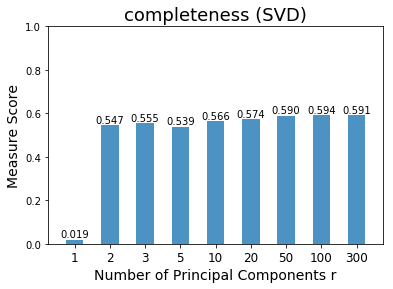

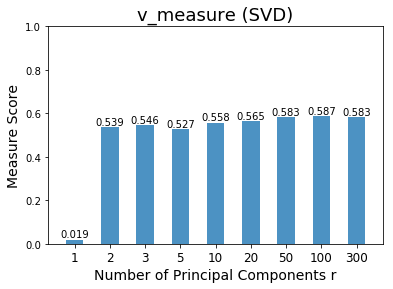

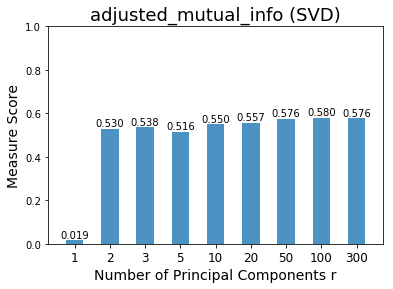

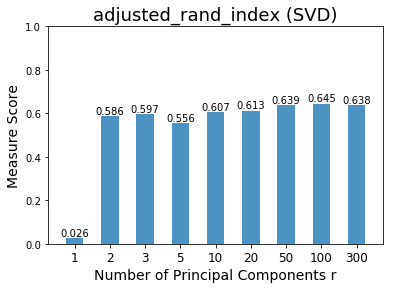

In [78]:
plot_histogram('SVD', 'homogeneity',svd_homogeneity_1)
plot_histogram('SVD', 'completeness',svd_completeness_1)
plot_histogram('SVD', 'v_measure',svd_v_measure_1)
plot_histogram('SVD', 'adjusted_mutual_info',svd_adjusted_mutual_info_1)
plot_histogram('SVD', 'adjusted_rand_index',svd_adjusted_rand_index_1)
               

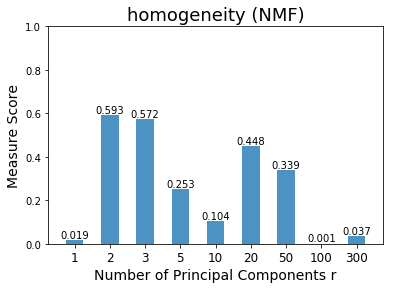

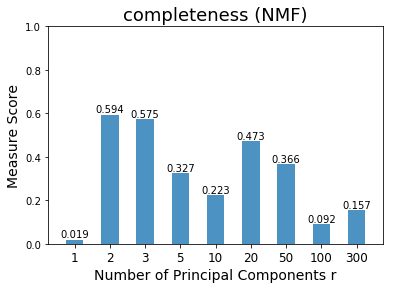

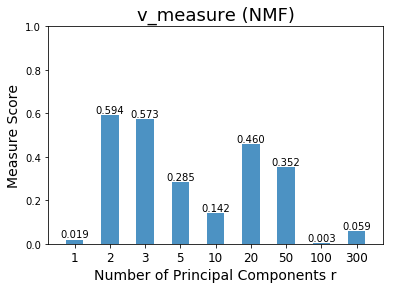

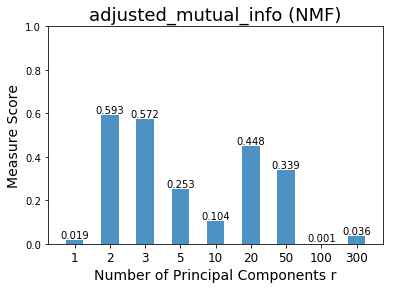

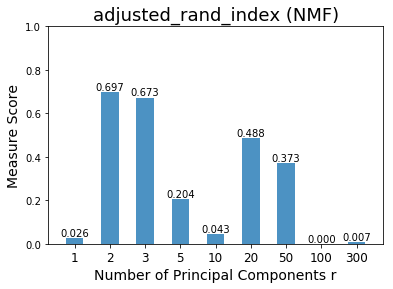

In [79]:
plot_histogram('NMF', 'homogeneity',nmf_homogeneity_1)
plot_histogram('NMF', 'completeness',nmf_completeness_1)
plot_histogram('NMF', 'v_measure',nmf_v_measure_1)
plot_histogram('NMF', 'adjusted_mutual_info',nmf_adjusted_mutual_info_1)
plot_histogram('NMF', 'adjusted_rand_index',nmf_adjusted_rand_index_1)
               

In [ ]:
# QUESTION 6: How do you explain the non-monotonic behavior of the measures as r
# increases?

In [ ]:
# QUESTION 7: Visualize the clustering results for:
#  SVD with its best r
#  NMF with its best r

In [ ]:
# QUESTION 8: Visualize the transformed data as in part (a).

In [ ]:
# QUESTION 9: Can you justify why the \logarithm transformation" may improve the
# clustering results?

In [ ]:
# QUESTION 10: Report the new clustering measures (except for the contingency ma-
# trix) for the clustering results of the transformed data.

In [ ]:
# QUESTION 11: Repeat the following for 20 categories using the same parameters as in
# 2-class case:
#  Transform corpus to TF-IDF matrix;
#  Directly perform K-means and report the 5 measures and the contingency matrix;

In [30]:
km_20 = pickle.load(open("km_20.pkl","rb"))
km_2 = pickle.load(open("km_2.pkl","rb"))

In [32]:
# pickle.dump(km_2,open("km_2.pkl","wb"))
# pickle.dump(km_20,open("km_20.pkl","wb"))

In [33]:
# # Apply K-means clustering with k=20 using the TF-IDF data. Use random_state=0, max_iter >= 1000, n_init>=30.
# N_CLUSTERS = 20
# RANDOM_STATE = 0
# MAX_ITER = 1000
# N_INIT = 30

# km_20 = k_means_clustering(nmf_dataset, n_clusters=N_CLUSTERS,random_state=RANDOM_STATE,max_iter=MAX_ITER,n_init=N_INIT)


# # km_20 = KMeans(n_clusters=N_CLUSTERS,random_state=RANDOM_STATE,max_iter=MAX_ITER,n_init=N_INIT)
# # start = time.time()
# # km_20.fit(X_tfidf)
# # print("Finished clustering with %i seeds in %f seconds" % (N_INIT, time.time()-start))

QUESTION 11: Report 5 Measures for K-Means Clustering for 20 classes
 
Contingency Matrix:
[[ 54  47   2   0   0   0  10   0   0   6   8  24   8 406 406   1   0   1
    0   0]
 [ 89  77   0   0  29   4   8   0   0   9  83 372   3  46 241   5   0   3
    0  16]
 [125  38   0   0  16  76  16   0   0  55  10  44 147   5 317   0   0   2
    2 129]
 [ 29  68   0   2  15  29 317   1   0  77  35   6  72   6 234   1   0   1
    0  70]
 [  0 118   0   0   0   0   1   0   0   0   0   2   0   0 209 228 363  67
    0   2]
 [  0 121  28   2   0   0   0   0   0   0   0   0   0   0 144  53  20 624
    1   3]
 [  0 134  13 476   0   0   0  26 108   0   0   0   0   1 197   6   0   5
   28   0]
 [  0 100  78  31   0   0   0 345  45   0   0   0   2   0 113   0   0   4
  281   0]]


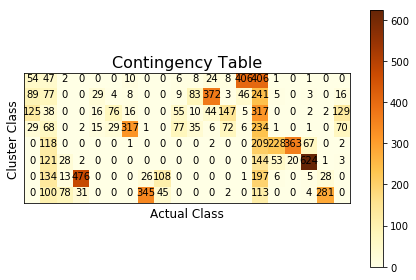

In [38]:
print("QUESTION 11: Report 5 Measures for K-Means Clustering for 20 classes\n ")
contin_matrix = metrics.cluster.contingency_matrix(dataset.target, km_20.labels_)
print("Contingency Matrix:")
print(contin_matrix)
# print_cluster_metrics(dataset.target, km_20)

plot_contingency_table(contin_matrix, actual_class_names=[], cluster_class_names=[])

In [ ]:
# QUESTION 12: Try different dimensions for both truncated SVD and NMF dimensionality reduction
# techniques and the different transformations of the obtained feature vectors as
# outlined in above parts.
# You don't need to report everything you tried, which will be tediously long. You are asked,
# however, to report your best combination, and quantitatively report how much better
# it is compared to other combinations. You should also include typical combinations
# showing what choices are desirable (or undesirable).

n_components: 300
NMF complete after 660.662622 seconds
Finished clustering with 30 seeds in 2.691199 seconds
Show Contingency Matrix:


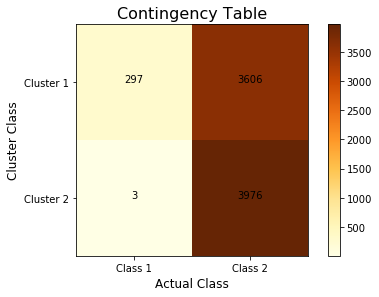

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.036575
Completeness Score: 0.156739
V-Measure Score: 0.059310
Adjusted Rand Index: 0.007000
Adjusted Mutual Information: 0.036486
SVD complete after 3.094053 seconds
Finished clustering with 30 seeds in 3.863864 seconds
Show Contingency Matrix:


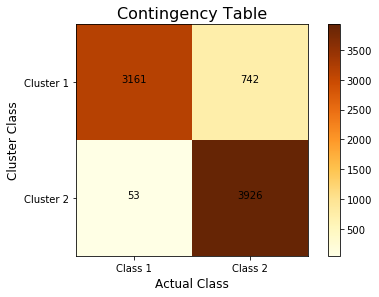

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.576353
Completeness Score: 0.590903
V-Measure Score: 0.583537
Adjusted Rand Index: 0.637197
Adjusted Mutual Information: 0.576314
n_components: 400
NMF complete after 867.443034 seconds
Finished clustering with 30 seeds in 2.860487 seconds
Show Contingency Matrix:


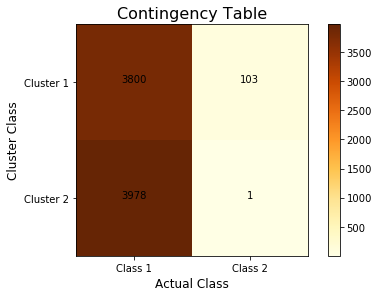

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.012469
Completeness Score: 0.123087
V-Measure Score: 0.022644
Adjusted Rand Index: 0.001167
Adjusted Mutual Information: 0.012378
SVD complete after 4.368805 seconds
Finished clustering with 30 seeds in 5.090170 seconds
Show Contingency Matrix:


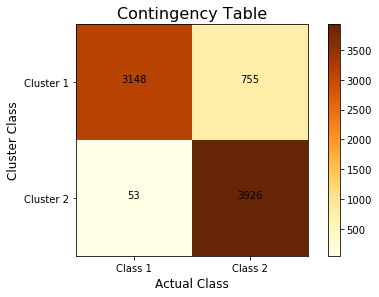

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.572034
Completeness Score: 0.587014
V-Measure Score: 0.579427
Adjusted Rand Index: 0.631940
Adjusted Mutual Information: 0.571994
n_components: 500
NMF complete after 1500.278257 seconds
Finished clustering with 30 seeds in 2.013870 seconds
Show Contingency Matrix:


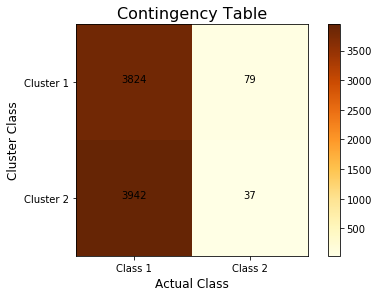

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.001521
Completeness Score: 0.013745
V-Measure Score: 0.002739
Adjusted Rand Index: 0.000317
Adjusted Mutual Information: 0.001429
SVD complete after 6.034286 seconds
Finished clustering with 30 seeds in 7.099152 seconds
Show Contingency Matrix:


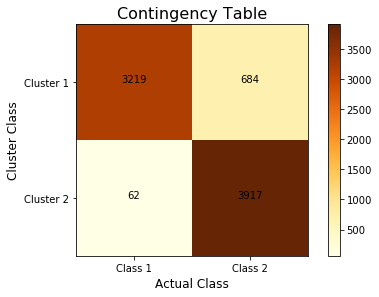

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.589667
Completeness Score: 0.601861
V-Measure Score: 0.595702
Adjusted Rand Index: 0.657204
Adjusted Mutual Information: 0.589629
n_components: 600
NMF complete after 1933.267088 seconds
Finished clustering with 30 seeds in 2.981632 seconds
Show Contingency Matrix:


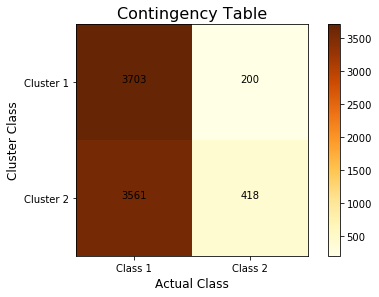

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.007379
Completeness Score: 0.018607
V-Measure Score: 0.010567
Adjusted Rand Index: 0.001984
Adjusted Mutual Information: 0.007288
SVD complete after 7.429061 seconds
Finished clustering with 30 seeds in 7.691154 seconds
Show Contingency Matrix:


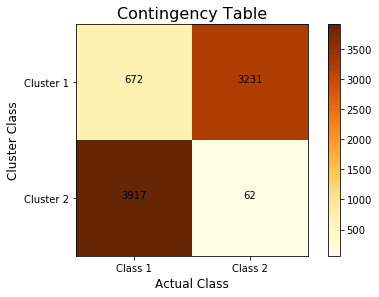

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.593828
Completeness Score: 0.605654
V-Measure Score: 0.599683
Adjusted Rand Index: 0.662151
Adjusted Mutual Information: 0.593791
n_components: 700
NMF complete after 2537.963072 seconds
Finished clustering with 30 seeds in 2.913255 seconds
Show Contingency Matrix:


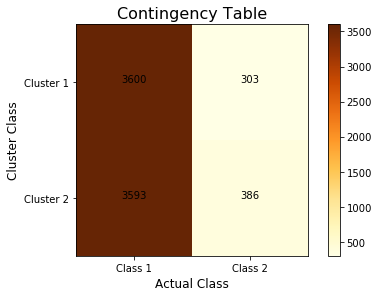

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.000851
Completeness Score: 0.001989
V-Measure Score: 0.001192
Adjusted Rand Index: 0.000027
Adjusted Mutual Information: 0.000759
SVD complete after 8.926330 seconds
Finished clustering with 30 seeds in 9.280417 seconds
Show Contingency Matrix:


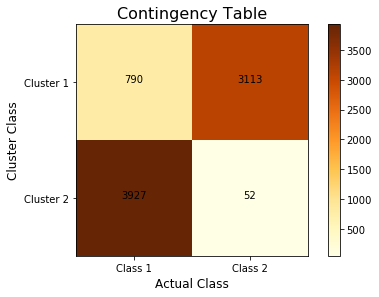

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.561291
Completeness Score: 0.577511
V-Measure Score: 0.569285
Adjusted Rand Index: 0.618296
Adjusted Mutual Information: 0.561251
n_components: 800
NMF complete after 2443.063701 seconds
Finished clustering with 30 seeds in 3.868598 seconds
Show Contingency Matrix:


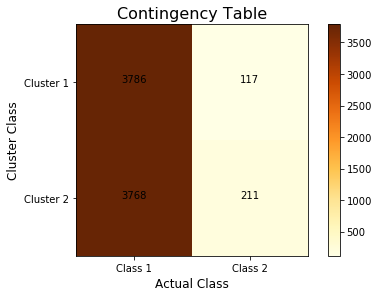

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.002437
Completeness Score: 0.009763
V-Measure Score: 0.003901
Adjusted Rand Index: 0.000104
Adjusted Mutual Information: 0.002346
SVD complete after 13.103448 seconds
Finished clustering with 30 seeds in 11.027879 seconds
Show Contingency Matrix:


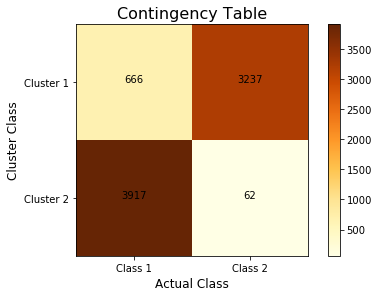

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.595922
Completeness Score: 0.607564
V-Measure Score: 0.601687
Adjusted Rand Index: 0.664632
Adjusted Mutual Information: 0.595885
n_components: 900
NMF complete after 3452.726037 seconds
Finished clustering with 30 seeds in 4.092192 seconds
Show Contingency Matrix:


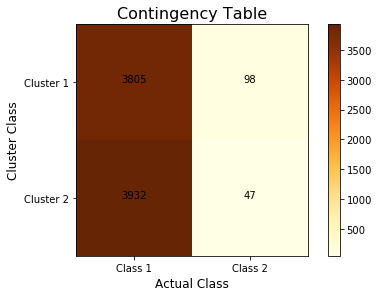

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.001801
Completeness Score: 0.013609
V-Measure Score: 0.003181
Adjusted Rand Index: 0.000415
Adjusted Mutual Information: 0.001709
SVD complete after 16.670658 seconds
Finished clustering with 30 seeds in 12.511734 seconds
Show Contingency Matrix:


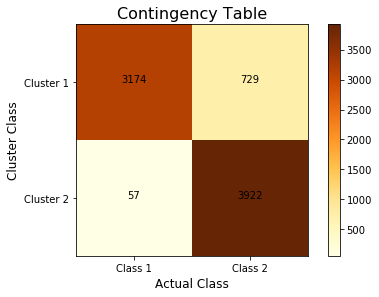

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.577850
Completeness Score: 0.591742
V-Measure Score: 0.584713
Adjusted Rand Index: 0.640848
Adjusted Mutual Information: 0.577812


In [40]:
nmf_homogeneity = []
nmf_completeness = []
nmf_v_measure = []
nmf_adjusted_mutual_info = []
nmf_adjusted_rand_index = []

svd_homogeneity = []
svd_completeness = []
svd_v_measure = []
svd_adjusted_mutual_info = []
svd_adjusted_rand_index = []


for r in range(300,1000,100):
    print('n_components:',r)
    nmf_dataset,nmf = nmf_dimension_reduction(X_tfidf, n_components = r)
    k_means_nmf = k_means_clustering(nmf_dataset, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
    nmf_homogeneity.append(k_means_nmf['homogeneity'])
    nmf_completeness.append(k_means_nmf['completeness'])
    nmf_v_measure.append(k_means_nmf['v_measure'])
    nmf_adjusted_mutual_info.append(k_means_nmf['adjusted_mutual_info'])
    nmf_adjusted_rand_index.append(k_means_nmf['adjusted_rand_index'])
    
    svd_dataset,svd = svd_dimension_reduction(X_tfidf, n_components = r)
    k_means_svd = k_means_clustering(svd_dataset, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
    svd_homogeneity.append(k_means_svd['homogeneity'])
    svd_completeness.append(k_means_svd['completeness'])
    svd_v_measure.append(k_means_svd['v_measure'])
    svd_adjusted_mutual_info.append(k_means_svd['adjusted_mutual_info'])
    svd_adjusted_rand_index.append(k_means_svd['adjusted_rand_index'])

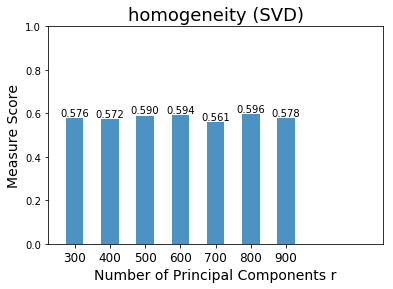

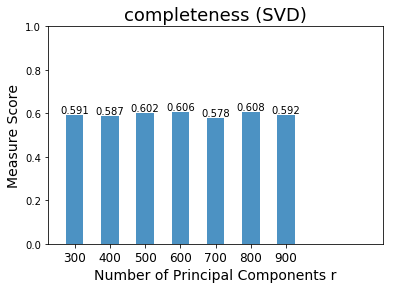

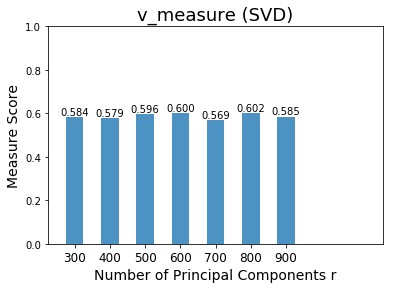

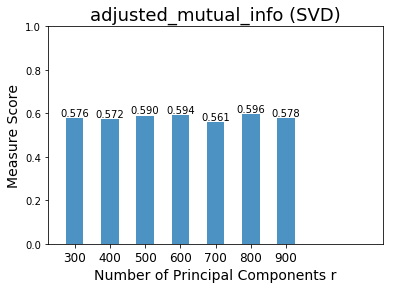

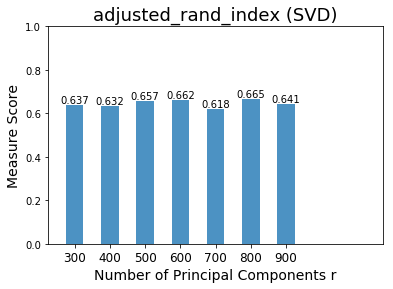

In [62]:

plot_histogram('SVD', 'homogeneity',svd_homogeneity, x_labels=range(300,1000,100), height=range(1,len(svd_homogeneity)+1))
plot_histogram('SVD', 'completeness',svd_completeness, x_labels=range(300,1000,100), height=range(1,len(svd_completeness)+1))
plot_histogram('SVD', 'v_measure',svd_v_measure, x_labels=range(300,1000,100), height=range(1,len(svd_v_measure)+1))
plot_histogram('SVD', 'adjusted_mutual_info',svd_adjusted_mutual_info, x_labels=range(300,1000,100), height=range(1,len(svd_adjusted_mutual_info)+1))
plot_histogram('SVD', 'adjusted_rand_index',svd_adjusted_rand_index, x_labels=range(300,1000,100), height=range(1,len(svd_adjusted_rand_index)+1))

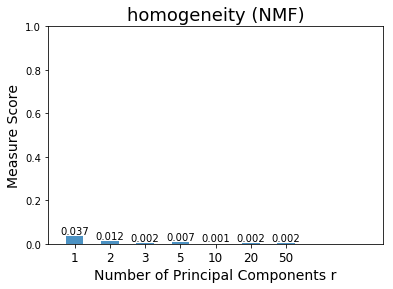

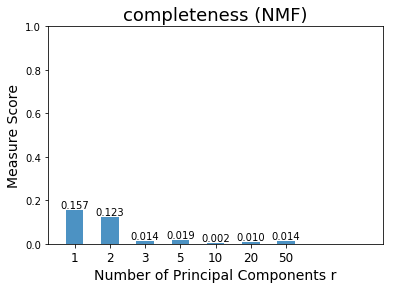

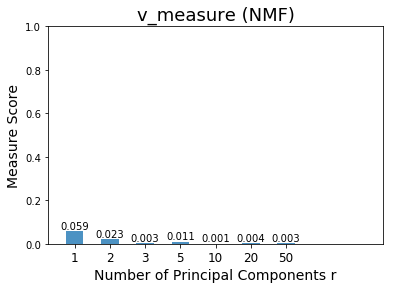

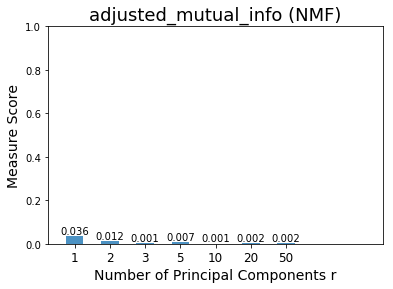

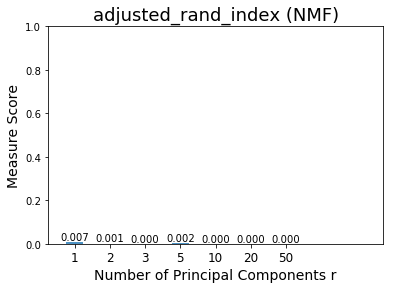

In [81]:
plot_histogram('NMF', 'homogeneity',nmf_homogeneity, height=range(1,len(nmf_homogeneity)+1))
plot_histogram('NMF', 'completeness',nmf_completeness, height=range(1,len(nmf_completeness)+1))
plot_histogram('NMF', 'v_measure',nmf_v_measure, height=range(1,len(nmf_v_measure)+1))
plot_histogram('NMF', 'adjusted_mutual_info',nmf_adjusted_mutual_info, height=range(1,len(nmf_adjusted_mutual_info)+1))
plot_histogram('NMF', 'adjusted_rand_index',nmf_adjusted_rand_index, height=range(1,len(nmf_adjusted_rand_index)+1))
               